In [658]:
from pymystem3 import Mystem
import os
import re
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt

In [647]:
mystem = Mystem()
stemmer = SnowballStemmer("russian")

In [648]:
f_test = open("dataset_40163_1.txt", "r")
test_sentences = f_test.read().split("\n")

In [649]:
f_train_enhanced = open("train_sentences_enhanced.txt", "r")
train_sentences_enhanced = f_train_enhanced.read().split("\n")

In [661]:
f_train = open("train_sentences.txt", "r")
train_sentences = f_train.read().split("\n")

In [650]:
lemmatized_test_sentences = [mystem.lemmatize(sentence) for sentence in test_sentences]

In [651]:
test_sentences[3]

'«Да не бросал я!'

In [652]:
names = set([])
orgs = set([])

In [653]:
collection_dir = os.fsencode("Collection3")
files = [os.fsdecode(el) for el in os.listdir(collection_dir)]

for file in files:
    if str(file).endswith(".ann"):
        f_cur = open("Collection3/" + str(file))
        content_lines = [elem for elem in f_cur.read().split("\n") if elem != ""]
        for line in content_lines:
            splitted = re.split("\t| ", line)
            tag = splitted[1]
            splitted = splitted[4:]
            if tag == "LOC":
                continue
                
            if tag == "PER":
                for elem in splitted:
                    if elem == "":
                        continue
                    lemmat_elem = stemmer.stem(elem)
                    if len(lemmat_elem) == 1:
                        continue
                    names.add(lemmat_elem)
                    
            if tag == "ORG":
                lemmat = stemmer.stem(" ".join(splitted)).strip("\n").strip()
                lemmat = lemmat.replace('"', '').replace('«', '').replace('»', '').replace("'", "")
                if len(lemmat) == 1:
                        continue
                orgs.add(lemmat)
                
                
                st = 0
                n = len(splitted)
                
                while st < n:
                    ln = 2
                    
                    while st + ln <= n:
                        lemmat = stemmer.stem(" ".join(splitted[st:st+ln])).strip("\n").strip()
                        lemmat = lemmat.replace('"', '').replace('«', '').replace('»', '').replace("'", "")
                        if len(lemmat) == 1:
                                continue
                        orgs.add(lemmat)
                        ln += 1
                    st += 1
                

In [654]:
for sentence in train_sentences_enhanced:
    words = sentence.split(" ")
    n = len(words)
    i = 0
    
    while i < n:
        if words[i].endswith("{PERSON}"):
            lemmatized = stemmer.stem(words[i][:-8]).strip("\n").strip()
            names.add(lemmatized)
            i += 1
            continue
        if words[i].endswith("{ORG}"):
            j = i + 1
            while j < n and words[j].endswith("{ORG}"):
                j += 1
            phrase_words = [elem.replace("{ORG}", "") for elem in words[i:j]]
            
            lemmat = stemmer.stem(" ".join(phrase_words)).strip("\n").strip()
            lemmat = lemmat.replace('"', '').replace('«', '').replace('»', '').replace("'", "")
            lemmat = lemmat.replace("(", "").replace(")", "")
            if len(lemmat) == 1:
                    i += 1
                    continue
            orgs.add(lemmat)
            
            
            st = 0
            lenn = len(phrase_words)

            while st < lenn:
                ln = 2

                while st + ln <= lenn:
                    lemmat = stemmer.stem(" ".join(phrase_words[st:st+ln])).strip("\n").strip()
                    lemmat = lemmat.replace('"', '').replace('«', '').replace('»', '').replace("'", "")
                    lemmat = lemmat.replace("(", "").replace(")", "")
                    #print(lemmat)
                    if len(lemmat) == 1:
                            continue
                    orgs.add(lemmat)
                    ln += 1
                st += 1
            
            
            i = j
            continue
        i += 1
    

In [ ]:
ans = []
quotes = ['"', "'", "«", "»"]

num_sent = 0

for sentence in test_sentences:
    if sentence == "":
        continue
    
    print(num_sent)
    num_sent += 1
    
    sentence_words = sentence.split(" ")
    n = len(sentence_words)
    i = 0
    
    cur_ans = []
    
    last_was = "NONE"
    
    while i < n:
        if sentence_words[i] == "":
            i += 1
            last_was = "NONE"
            continue
            
        shift = 0
        if i != 0:
            shift = 1
            
        j = i
        max_j = -1
        
        while j < n:
            phrase = " ".join(sentence_words[i:j+1]).replace('"', '').replace('«', '').replace('»', '').replace("'", "")
            phrase = phrase.replace("(", "").replace(")", "")
            lemmatized_phrase = stemmer.stem(phrase).strip("\n").strip()
            if lemmatized_phrase == "":
                j += 1
                continue
            #print("PHRASE" + str(lemmatized_phrase) + "!")
            if lemmatized_phrase in orgs:
                #print("True")
                max_j = j
            j += 1
        
        if max_j != -1:
            if max_j == i and len(sentence_words[i]) == 1:
                i += 1
                last_was = "NONE"
                continue
            
            for k in range(i, max_j + 1):
                start_ind = len(" ".join(sentence_words[:k])) + shift
                lenght = len(sentence_words[k])
                cur_ans.append(str(start_ind) + " " + str(lenght) + " " + "ORG")
                last_was = "ORG"
            #print("PHRASE", sentence_words[i:max_j + 1])
            #print("I MAX_J", i, max_j)
            i = max_j + 1
            #last_was = "ORG"
            continue
            
        cur_word = sentence_words[i].replace('"', '').replace('«', '').replace('»', '').replace("'", "").replace("(", "").replace(")", "")
        
        #print("CUR_WORD", cur_word)
        #print("WORD", sentence_words[i])
        
        if len(cur_word) <= 1:
            i += 1
            last_was = "NONE"
            continue
        
        if cur_word.isupper():
            start_ind = len(" ".join(sentence_words[:i])) + shift
            lenght = len(sentence_words[i])
            cur_ans.append(str(start_ind) + " " + str(lenght) + " " + "ORG")
            last_was = "ORG"
            i += 1
            continue 
            
        if sentence_words[i][0] in quotes and sentence_words[i][-1] in quotes and sentence_words[i][1:-1][0].isupper():
            start_ind = len(" ".join(sentence_words[:i])) + shift
            lenght = len(sentence_words[i])
            if lenght == 1:
                continue
            
            cur_ans.append(str(start_ind) + " " + str(lenght) + " " + "ORG")
            last_was = "ORG"
            i += 1
            continue
        
        if not sentence_words[i][0].isupper():
            i += 1
            last_was = "NONE"
            continue
        
        lemmatized = stemmer.stem(sentence_words[i])
        lemmatized = lemmatized.replace('"', '').replace('«', '').replace('»', '').replace("'", "").replace("(", "").replace(")", "")            
                
        if last_was == "PER" or lemmatized in names:
            #print(lemmatized)
            start_ind = len(" ".join(sentence_words[:i])) + shift
            lenght = len(sentence_words[i])
            
            cur_ans.append(str(start_ind) + " " + str(lenght) + " " + "PERSON")
            last_was = "PER"
            i += 1
            continue
        last_was = "NONE"  
        i += 1
    
    cur_ans.append("EOL")
    #print(cur_ans)
    ans.append(" ".join(cur_ans))

In [657]:
print(len(ans))

f_ans = open("ans.txt", "w")
f_ans.write("\n".join(ans))
f_ans.close()

500


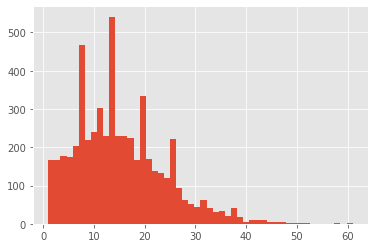

In [662]:
plt.style.use("ggplot")
plt.hist([len(s.split(" ")) for s in test_sentences] + 
         [len(s.split(" ")) for s in train_sentences_enhanced] + 
         [len(s.split(" ")) for s in train_sentences], bins=50)
plt.show()